# Using Neural Network Formulations in OMLT

In this notebook we show how different neural networks can be formulated within Pyomo using OMLT. It specifically demonstrates the following representations:
- A neural network with smooth sigmoid activation functions represented using full-space and reduced-space formulations
- A neural network with non-smooth relu activaiton functions represented using complementarity and mixed integer formulations
- A neural network with mixed relu and sigmoid activation functions represented using complementarity and full-space formulations

This notebook assumes you have a working tensorflow environment in addition to other necessary packages denoted below.

## Library Setup
Start by importing the libraries used in this project:

Base libraries used this notebook: <br>
- `numpy`, `pandas`: data manipulation <br>
- `json`: needed to write neural network parameters (e.g. scaling information) <br>
- `matplotlib`: used for plotting the results in this example

In this notebook we import a neural network into Pyomo from Keras (through tensorflow) to train a simple neural network. We consequently need working Pyomo and Tensorflow packages.
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `tensorflow`: the machine learning language we use to train our neural network

We import the following classes from OMLT:
 - `OmltBlock`: A Pyomo custom block that can represent machine learning models (such as neural networks)

In [169]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

import pyomo.environ as pyo
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, NeuralNetworkFormulation, ReducedSpaceNeuralNetworkFormulation
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io import keras_reader
import omlt

## Import the Data

We begin by training a neural network that learns some simulation data given by the following imported dataframe. The data contains a single input `x` and a single output `y` with 10,000 total samples

In [170]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0]);

The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

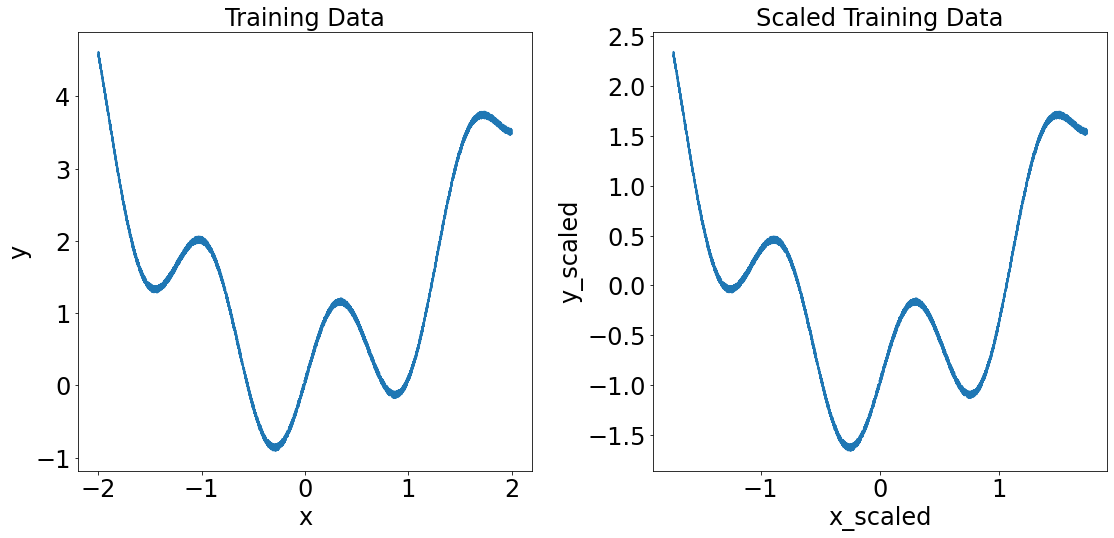

In [171]:
x = df["x"]
y = df["y"]

mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax1.set_title("Training Data")


ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");
ax2.set_title("Scaled Training Data")

plt.tight_layout()

## Train the Neural Network
After importing the dataset we use keras to train three neural network models. Each neural network contains 2 layers with 100 nodes per layer with a single output layer. The first network (`nn1`) uses sigmoid activation functions, the second network (`nn2`) uses relu activations, and the last network (`nn3`) mixes relu and sigmoid activation functions. We use the ADAM optimizer and train the first two neural networks for 50 epochs. We train `nn3` for 150 epochs since it is difficult to obtain a good fit with the mixed network.

In [172]:
#sigmoid neural network
nn1 = Sequential(name='sin_wave_sigmoid')
nn1.add(Input(1))
nn1.add(Dense(100, activation='sigmoid'))
nn1.add(Dense(100, activation='sigmoid'))
nn1.add(Dense(1))
nn1.compile(optimizer=Adam(), loss='mse')

#relu neural network
nn2 = Sequential(name='sin_wave_relu')
nn2.add(Input(1))
nn2.add(Dense(100, activation='relu'))
nn2.add(Dense(100, activation='relu'))
nn2.add(Dense(1))
nn2.compile(optimizer=Adam(), loss='mse')

#mixed neural network
nn3 = Sequential(name='sin_wave_mixed')
nn3.add(Input(1))
nn3.add(Dense(100, activation='sigmoid'))
nn3.add(Dense(100, activation='relu'))
nn3.add(Dense(1))
nn3.compile(optimizer=Adam(), loss='mse')

In [173]:
history1 = nn1.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=50)
history2 = nn2.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=50)
history3 = nn3.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=150)

Epoch 1/50
313/313 [==============================] - 1s 5ms/step - loss: 1.0096
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 1.0010
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.9923
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.9511
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.5483
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2628
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2347
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2202
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2010
Epoch 10/50
313/313 [==============================] - 1s 2ms/step - loss: 0.1766
Epoch 11/50
313/313 [==============================] - 1s 2ms/step - loss: 0.1515
Epoch 12/50
313/313 [==============================] - 1s 2ms/step - loss: 0.1257
Epoch 13/50
313/313 [====

313/313 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 99/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 100/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 101/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0023
Epoch 102/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 103/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 104/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 105/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 106/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 107/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 108/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0024
Epoch 109/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 1

## Check the predictions
Before we employ our trained neural networks in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fit.

In [174]:
#nn1
y_predict_scaled_sigmoid = nn1.predict(x=df['x_scaled'])
y_predict_sigmoid = y_predict_scaled_sigmoid*(std_data['y']) + mean_data['y']

#nn2
y_predict_scaled_relu = nn2.predict(x=df['x_scaled'])
y_predict_relu = y_predict_scaled_relu*(std_data['y']) + mean_data['y']

#nn3
y_predict_scaled_mixed = nn3.predict(x=df['x_scaled'])
y_predict_mixed = y_predict_scaled_mixed*(std_data['y']) + mean_data['y']

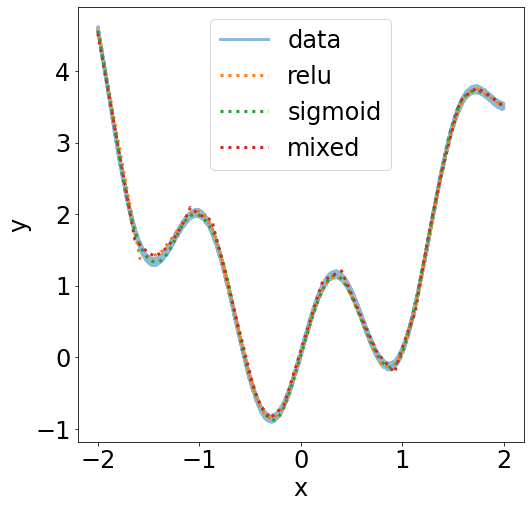

In [175]:
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu")
ax.plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",label = "sigmoid")
ax.plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted",label = "mixed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

## Formulating Neural Networks with OMLT
We now show how OMLT can formulate neural networks in Pyomo. We show how to specify different representations of neural networks which we will use to solve optimization problems in Pyomo.
<br><br>
OMLT can formulate what we call full-space and reduced-space neural network representations in Pyomo using the `NeuralNetworkFormulation` object (for full-space) and `ReducedSpaceNeuralNetworkFormulation` object (for reduced-space). The reduced-space representation can be represented more compactly within an optimization setting, but we will see that full-space representation is necessary to represent non-smooth activation functions (e.g. ReLU).

### Reduced Space  (supports smooth activations) <br>
The reduced-space representation (`ReducedSpaceNeuralNetworkFormulation`) provided by OMLT hides intermediate neural network variables and activation functions from the underlying optimizer and represents the neural network using one constraint as following.

$$\hat{y} = N(x)$$

Here, $\hat{y}$ is a vector of outputs from the neural network, $x$ is a vector of inputs, and $N(\cdot)$ represents the encoded neural network function that uses weights and biases to map $x \rightarrow \hat{y}$. OMLT builds the reduced-space formulation by encoding layer and activation functions as Pyomo `Expression` objects.

### Full Space (supports smooth and non-smooth activations) <br>
The full space formulation (`NeuralNetworkFormulation`) presents intermediate variables associated with the neural network nodes and activation functions to the optimizer. This is represented by the following set of equations where $x$ and $\hat{y}$ are again the neural network input and output vectors, and we introduce $\hat{z}_{\ell}$ and $z_{\ell}$ to represent pre-activation and post-activation values for each each layer $\ell$. We further use the notation $\hat z_{\ell,i}$ to denote node $i$ in layer $\ell$. As such, the first equation maps the input to the first layer $z_0$, the second equation represents the pre-activation values, the third equation applies the activation function, and the last equation maps the final layer to the output.

$\begin{align*}
& x = z_0 &\\
& \hat z_{\ell,i} = \sum_{j{=}1}^{N_{\ell-1}} w_{ij} z_j + b_i & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& z_{\ell,i} = \sigma(\hat z_{\ell}) &  \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& \hat{y} = z_{N_L} &
\end{align*}
$

### Full Space ReLU with Binary Variables
The full space formulation supports non-smooth ReLU activation functions (i.e. the function $z_i = max(0,\hat{z})$) by using binary indicator variables. When using `NeuralNetworkFormulation` with a `NetworkDefinition` object that contains ReLU activations, OMLT will formulate the below set of variables and constraints for each node in the ReLU layer. Here, $q_i$ is a binary indicator variable that determines whether the output is $0$ or $\hat{z}_i$ on node $i$ and $M_i^U$ and $M_i^L$ are 'BigM' constants used to enforce the ReLU logic. Values for 'BigM' are often taken to be arbitrarily large numbers, but OMLT will automatically determine values by propagating the bounds on the input variables.

$
\begin{align*}
& z_{\ell,i} \ge \hat{z}_{\ell,i} & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}\\
& z_{\ell,i} \ge 0 & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}\\
& z_{\ell,i} \le M_{\ell,i}^L q_{\ell,i} & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& z_{\ell,i} \le \hat{z}_{\ell,i} - M_{\ell,i}^U(1-q_{\ell,i}) & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}
\end{align*} 
$


### Full Space ReLU with Complementarity Constraints
ReLU activation functions can also be represented using the following complementarity condition:
$
\begin{align*}
0 \le (z_{\ell,i} - \hat{z}_{\ell,i}) \perp z_{\ell,i} \ge 0 & \quad \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}
\end{align*}
$

This condition means that both of the expressions must be satisfied, where exactly one expression must be satisfied with equality. Hence, we must have that $z_{\ell,i} \ge \hat{z}_{\ell,i}$ and $z_{\ell,i} \ge 0$ with either $z_{\ell,i} = \hat{z}_{\ell,i}$, or $z_{\ell,i} = 0$.

OMLT uses a `ComplementarityReLUActivation` object to specify that ReLU activation functions should be formulated using complementarity conditions. Within the formulation code, it uses `pyomo.mpec` to transform this complementarity condition into nonlinear constraints which facilitates using smooth optimization solvers (such as Ipopt) to optimize over ReLU activation functions.

## Solving Optimization Problems with Neural Networks using OMLT

We now show how to use the above neural network formulations in OMLT for our trained neural networks: `nn1`, `nn2`, and `nn3`.

$
\begin{align*} 
& \min \ \hat{y}\\
& s.t. \hat{y} = N(x) 
\end{align*}
$

We begin by instantiating a Pyomo `ConcreteModel` and create variables that represent our neural network input `x` and output `y`. We also create an objective function that seeks to minimize the output `y`.

### Setup scaling and input bounds
The neural network formulations created with OMLT need to include scaling information and input bounds to maintain correctness of the optimization problem. 

In [176]:
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.731791015101997, 1.731791015101997)}


### Neural Network 1: Sigmoid Activations with Full-Space and Reduced-Space Formulations
The first neural network contains sigmoid activation functions which we formulate with full-space and reduced-space representation

#### Reduced Space Model
We begin with the reduced-space formulation, but each example uses the same general workflow:
- Use the `keras_reader` to import the neural network into a OMLT `NetworkDefinition` object.
- Create a Pyomo model with variables `x` and `y` where we intend to minimize `y`.
- Create an `OmltBlock`.
- Create a formulation object. Note that we use `ReducedSpaceNeuralNetworkFormulation` for the reudced-space. 
- Build the formulation object on the `OmltBlock`.
- Add constraints connecting `x` to the neural network input and `y` to the neural network output.
- Solve with an optimization solver (this example uses ipopt).
- Query the solution.

We also print model size and solution time in the following cell. Note that the reduced-space model only contains 6 variables (`x` and `y`, and the neural network scaled and unscaled input and output.

In [177]:
#create a network definition
net_sigmoid = keras_reader.load_keras_sequential(nn1,scaler,input_bounds)

#create a pyomo model with variables x and y
model1_reduced = pyo.ConcreteModel()
model1_reduced.x = pyo.Var(initialize = 0)
model1_reduced.y = pyo.Var(initialize = 0)
model1_reduced.obj = pyo.Objective(expr=(model1_reduced.y))

#create an OmltBlock
model1_reduced.nn = OmltBlock()

#use the reduced-space formulation
formulation1_reduced = ReducedSpaceNeuralNetworkFormulation(net_sigmoid)
model1_reduced.nn.build_formulation(formulation1_reduced)

#connect pyomo variables to the neural network
@model1_reduced.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model1_reduced.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_1_reduced = pyo.SolverFactory('ipopt').solve(model1_reduced, tee=True)
solution_1_reduced = (pyo.value(model1_reduced.x),pyo.value(model1_reduced.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequ

In [178]:
#print out model size and solution values
print("Reduced Space Solution:")
print("# of variables: ",model1_reduced.nvariables())
print("# of constraints: ",model1_reduced.nconstraints())
print("x = ", solution_1_reduced[0])
print("y = ", solution_1_reduced[1])
print("Solve Time: ", status_1_reduced['Solver'][0]['Time'])

Reduced Space Solution:
# of variables:  6
# of constraints:  5
x =  -1.4278897236253703
y =  1.3301960151829075
Solve Time:  0.13344788551330566


#### Full Space Model
For the full-space representation we use `NeuralNetworkFormulation` instead of `ReducedSpaceNeuralNetworkFormulation`. The key difference is that this formulation creates additional variables and constraints to represent each node and activation function in the neural network.

Note that when we print this model there are over 400 variables and constraints each owing to the number of neural network nodes. The solution consequently takes longer with more iterations and this effect is more pronounced for larger models. Also note that the full-space finds a different local minima.

In [179]:
net_sigmoid = keras_reader.load_keras_sequential(nn1,scaler,input_bounds)

model1_full = pyo.ConcreteModel()
model1_full.x = pyo.Var(initialize = 0)
model1_full.y = pyo.Var(initialize = 0)
model1_full.obj = pyo.Objective(expr=(model1_full.y))
model1_full.nn = OmltBlock()

formulation2_full = NeuralNetworkFormulation(net_sigmoid)
model1_full.nn.build_formulation(formulation2_full)

@model1_full.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model1_full.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_1_full = pyo.SolverFactory('ipopt').solve(model1_full, tee=True)
solution_1_full = (pyo.value(model1_full.x),pyo.value(model1_full.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    10815
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      405
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequ

In [180]:
#print out model size and solution values
print("Full Space Solution:")
print("# of variables: ",model1_full.nvariables())
print("# of constraints: ",model1_full.nconstraints())
print("x = ", solution_1_full[0])
print("y = ", solution_1_full[1])
print("Solve Time: ", status_1_full['Solver'][0]['Time'])

Full Space Solution:
# of variables:  409
# of constraints:  408
x =  -0.2700294232987669
y =  -0.8760156212973679
Solve Time:  0.355771541595459


### Model 2: ReLU Neural Network using Complementarity Constraints and Binary Variables
The second neural network contains ReLU activation functions which we represent using complementarity constraints and binary variables.

#### ReLU Complementarity Constraints
To represent ReLU using complementarity constraints we use the `ComplementarityReLUActivation` object which we pass as a keyword argument to a `NeuralNetworkFormulation`. This overrides the default relu behavior which uses binary variables (shown in the next model). Importantly, the complementarity formulation allows us to solve the model using a continuous solver.

In [181]:
net_relu = keras_reader.load_keras_sequential(nn2,scaler,input_bounds)

model2_comp = pyo.ConcreteModel()
model2_comp.x = pyo.Var(initialize = 0)
model2_comp.y = pyo.Var(initialize = 0)
model2_comp.obj = pyo.Objective(expr=(model2_comp.y))
model2_comp.nn = OmltBlock()

formulation2_comp = NeuralNetworkFormulation(net_relu,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model2_comp.nn.build_formulation(formulation2_comp)

@model2_comp.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model2_comp.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_2_comp = pyo.SolverFactory('ipopt').solve(model2_comp, tee=True)
solution_2_comp = (pyo.value(model2_comp.x),pyo.value(model2_comp.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    11015
Number of nonzeros in inequality constraint Jacobian.:      600
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      609
                     variables with only lower bounds:      200
                variables with lower and upper bounds:      103
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequ

In [182]:
#print out model size and solution values
print("ReLU Complementarity Solution:")
print("# of variables: ",model2_comp.nvariables())
print("# of constraints: ",model2_comp.nconstraints())
print("x = ", solution_2_comp[0])
print("y = ", solution_2_comp[1])
print("Solve Time: ", status_2_comp['Solver'][0]['Time'])

ReLU Complementarity Solution:
# of variables:  609
# of constraints:  808
x =  -0.26997673744548334
y =  -0.86224050359779
Solve Time:  0.23065590858459473


#### ReLU with Binary Variables and BigM Constraints
For the binary variable formulation of ReLU we use the default activation function settings. These are applied automatically if a `NetworkDefinition` contains ReLU activation functions. 

Note that we solve the optimization problem with Cbc which can handle binary decisions. While the solution takes considerably longer than the continuous complementarity formulation, it is a gauranteed global minimum.

In [183]:
net_relu = keras_reader.load_keras_sequential(nn2,scaler,input_bounds)

model2_bigm = pyo.ConcreteModel()
model2_bigm.x = pyo.Var(initialize = 0)
model2_bigm.y = pyo.Var(initialize = 0)
model2_bigm.obj = pyo.Objective(expr=(model2_bigm.y))
model2_bigm.nn = OmltBlock()

formulation2_bigm = NeuralNetworkFormulation(net_relu)
model2_bigm.nn.build_formulation(formulation2_bigm)

@model2_bigm.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model2_bigm.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_2_bigm = pyo.SolverFactory('cbc').solve(model2_bigm, tee=True)
solution_2_bigm = (pyo.value(model2_bigm.x),pyo.value(model2_bigm.y))

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Oct 15 2020 

command line - /home/jhjalvi/anaconda3/envs/tensorflow/bin/cbc -printingOptions all -import /tmp/tmpradll839.pyomo.lp -stat=1 -solve -solu /tmp/tmpradll839.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 688 (-321) rows, 492 (-118) columns and 11268 (-748) elements
Statistics for presolved model
Original problem has 200 integers (200 of which binary)
Presolved problem has 193 integers (193 of which binary)
==== 491 zero objective 2 different
491 variables have objective of 0
1 variables have objective of 1.37862
==== absolute objective values 2 different
491 variables have objective of 0
1 variables have objective of 1.37862
==== for integers 193 zero objective 1 different
193 variables have objective of 0
==== for integers absolute objective values 1 different
193 variables have objective of 0
===== end objective counts


Problem has 688 rows, 492 columns (1 with o

In [184]:
#print out model size and solution values
print("ReLU BigM Solution:")
print("# of variables: ",model2_bigm.nvariables())
print("# of constraints: ",model2_bigm.nconstraints())
print("x = ", solution_2_bigm[0])
print("y = ", solution_2_bigm[1])
print("Solve Time: ", status_2_bigm['Solver'][0]['Time'])

ReLU BigM Solution:
# of variables:  609
# of constraints:  1008
x =  -0.26997592
y =  -0.86221334
Solve Time:  308.61534428596497


### Neural Network 3: Mixed ReLU and Sigmoid Activation Functions
The last neural network contains both ReLU and sigmoid activation functions. These networks can be represented by using the complementarity formulation of relu and mixing it with the full-space formulation for the sigmoid functions.

In [185]:
net_mixed = keras_reader.load_keras_sequential(nn3,scaler,input_bounds)

model3_mixed = pyo.ConcreteModel()
model3_mixed.x = pyo.Var(initialize = 0)
model3_mixed.y = pyo.Var(initialize = 0)
model3_mixed.obj = pyo.Objective(expr=(model3_mixed.y))
model3_mixed.nn = OmltBlock()

formulation3_mixed = NeuralNetworkFormulation(net_mixed,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model3_mixed.nn.build_formulation(formulation3_mixed)

@model3_mixed.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model3_mixed.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_3_mixed = pyo.SolverFactory('ipopt').solve(model3_mixed, tee=True)
solution_3_mixed = (pyo.value(model3_mixed.x),pyo.value(model3_mixed.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    10915
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      509
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      303
                     variables with only upper bounds:        0
Total number of equality constraints.................:      408
Total number of inequ

In [186]:
#print out model size and solution values
print("Mixed NN Solution:")
print("# of variables: ",model3_mixed.nvariables())
print("# of constraints: ",model3_mixed.nconstraints())
print("x = ", solution_3_mixed[0])
print("y = ", solution_3_mixed[1])
print("Solve Time: ", status_3_mixed['Solver'][0]['Time'])

Mixed NN Solution:
# of variables:  509
# of constraints:  608
x =  -0.3027177364612855
y =  -0.855324577032481
Solve Time:  0.21193885803222656


We lastly plot the results of each optimization. Some of the main take-aways from this notebook are as follows:
- Various dense neural network architectures can be represented in Pyomo using OMLT
- The reduced-space formulation tends to provide computationally tractable approaches to represent neural networks with smooth activations and obtain local solutions
- The full-space formulation permits formulation ReLU using either complementarity or Big-M approaches
- The full-space allows one to optimize over neural networks that contain mixed activation functions by formulating ReLU as complementarity
- Using binary variables to represent ReLU can attain global solutions (if the rest of the problem is not nonlinear), whereas complementarity provides local solutions but tends to be more scalable.

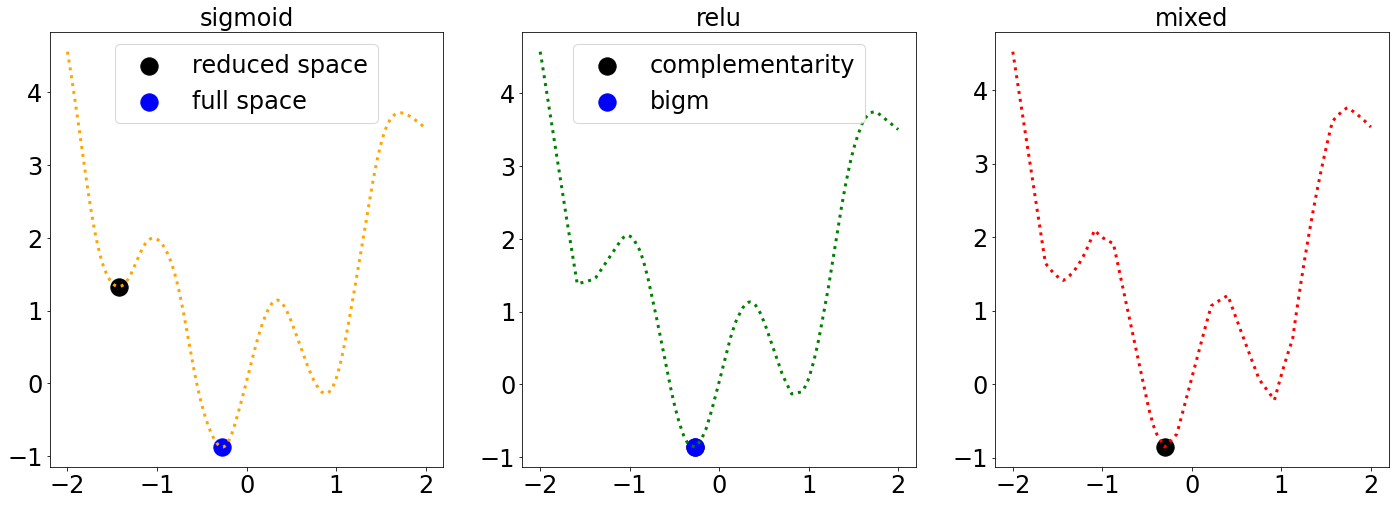

In [187]:
fig,axs = plt.subplots(1,3,figsize = (24,8))
axs[0].plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",color = "orange")
axs[0].set_title("sigmoid")
axs[0].scatter([solution_1_reduced[0]],[solution_1_reduced[1]],color = "black",s = 300, label="reduced space")
axs[0].scatter([solution_1_full[0]],[solution_1_full[1]],color = "blue",s = 300, label="full space")
axs[0].legend()

axs[1].plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",color = "green")
axs[1].set_title("relu")
axs[1].scatter([solution_2_comp[0]],[solution_2_comp[1]],color = "black",s = 300, label="complementarity")
axs[1].scatter([solution_2_bigm[0]],[solution_2_bigm[1]],color = "blue",s = 300, label="bigm")
axs[1].legend()

axs[2].plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted", color = "red")
axs[2].set_title("mixed")
axs[2].scatter([solution_3_mixed[0]],[solution_3_mixed[1]],color = "black",s = 300);